# Genre Classification

## Load in data

In [111]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Read in data from file
df = pd.read_csv('data/booksummaries.txt', header=None, sep='\t')
df.columns = ['wikipedia_article_id', 'freebase_id', 'title', 'author', 'pub_date', 'genre', 'summary']
# Remove extraneous features - wikipedia_article_id, freebase_id, author, pub_date
df = df.drop(labels=['wikipedia_article_id', 'freebase_id', 'author', 'pub_date'], axis=1)

print(df.head())

                                       title  \
0                                Animal Farm   
1                         A Clockwork Orange   
2                                 The Plague   
3  An Enquiry Concerning Human Understanding   
4                       A Fire Upon the Deep   

                                               genre  \
0  {"/m/016lj8": "Roman \u00e0 clef", "/m/06nbt":...   
1  {"/m/06n90": "Science Fiction", "/m/0l67h": "N...   
2  {"/m/02m4t": "Existentialism", "/m/02xlf": "Fi...   
3                                                NaN   
4  {"/m/03lrw": "Hard science fiction", "/m/06n90...   

                                             summary  
0   Old Major, the old boar on the Manor Farm, ca...  
1   Alex, a teenager living in near-future Englan...  
2   The text of The Plague is divided into five p...  
3   The argument of the Enquiry proceeds by a ser...  
4   The novel posits that space around the Milky ...  


## Data Pre-Processing
- Add spaces around special characters
- Remove useless spaces and multiple newlines
- Remove stopwords
- Remove all books without genres, titles, or summaries

In [112]:
import re

# example code taken from fast-bert
def spec_add_spaces(t: str) -> str:
    "Add spaces around / and # in `t`. \n"
    return re.sub(r"([/#\n])", r" \1 ", t)

def rm_useless_spaces(t: str) -> str:
    "Remove multiple spaces in `t`."
    return re.sub(" {2,}", " ", t)

def replace_multi_newline(t: str) -> str:
    return re.sub(r"(\n(\s)*){2,}", "\n", t)

def clean_text(input_text):
    text = replace_multi_newline(input_text)
    text = spec_add_spaces(text)
    text = rm_useless_spaces(text)
    text = text.strip()
    return text

In [113]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

print('Size of dataset before preprocessing:', len(df))

# Remove any books which don't have genres
df.dropna(subset=['genre'], inplace=True)

print('Size of dataset after removing missing genres:', len(df))

# Remove any books which don't have titles
df.dropna(subset=['title'], inplace=True)

print('Size of dataset after removing missing titles:', len(df))

# Remove any books which don't have summaries
df.dropna(subset=['summary'], inplace=True)

print('Size of dataset after removing missing summaries:', len(df))
print('Size of dataset after preprocessing:', len(df))

# Tokenize titles & convert to lower case - add to tokenized_title column
df['token_title'] = df['title'].apply(lambda x: nltk.word_tokenize(clean_text(x.lower())))

# Tokenize summaries & convert to lower case - add to tokenized_summary column
df['token_summary'] = df['summary'].apply(lambda x: nltk.word_tokenize(clean_text(x.lower())))

# Remove all stop words from all summaries & titles
stop = stopwords.words('english')
df['token_summary'] = df['token_summary'].apply(lambda x: [word for word in x if word not in (stop)])
df['token_title'] = df['token_title'].apply(lambda x: [word for word in x if word not in (stop)])
df['token_summary'] = [' '.join(map(str, l)) for l in df['token_summary']]
df['token_title'] = [' '.join(map(str, l)) for l in df['token_title']]
df["title_summary"] = df["token_title"] + " " + df["token_summary"]

Size of dataset before preprocessing: 16559
Size of dataset after removing missing genres: 12841
Size of dataset after removing missing titles: 12841
Size of dataset after removing missing summaries: 12841
Size of dataset after preprocessing: 12841


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\crzas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\crzas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\crzas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [114]:
# Format the genre field
formatted_genres = []
genre_dict = dict()
for g in df['genre']:
    subg = []
    genre_dict = eval(g)
    for k in genre_dict.keys():
        subg.append(genre_dict[k])
    formatted_genres.append(subg)
df['formatted_genre'] = formatted_genres
print(df.head())

                            title  \
0                     Animal Farm   
1              A Clockwork Orange   
2                      The Plague   
4            A Fire Upon the Deep   
5  All Quiet on the Western Front   

                                               genre  \
0  {"/m/016lj8": "Roman \u00e0 clef", "/m/06nbt":...   
1  {"/m/06n90": "Science Fiction", "/m/0l67h": "N...   
2  {"/m/02m4t": "Existentialism", "/m/02xlf": "Fi...   
4  {"/m/03lrw": "Hard science fiction", "/m/06n90...   
5  {"/m/098tmk": "War novel", "/m/016lj8": "Roman...   

                                             summary          token_title  \
0   Old Major, the old boar on the Manor Farm, ca...          animal farm   
1   Alex, a teenager living in near-future Englan...     clockwork orange   
2   The text of The Plague is divided into five p...               plague   
4   The novel posits that space around the Milky ...       fire upon deep   
5   The book tells the story of Paul Bäumer, a Ge...  q

In [115]:
genres = set()
for x in df['formatted_genre']:
    genres.update(x)
print('# of unique genres:', len(genres))

# of unique genres: 227


Genre distribution: {5: 653, 6: 258, 4: 1428, 2: 3532, 1: 4555, 3: 2275, 9: 11, 7: 101, 8: 26, 11: 1, 10: 1}


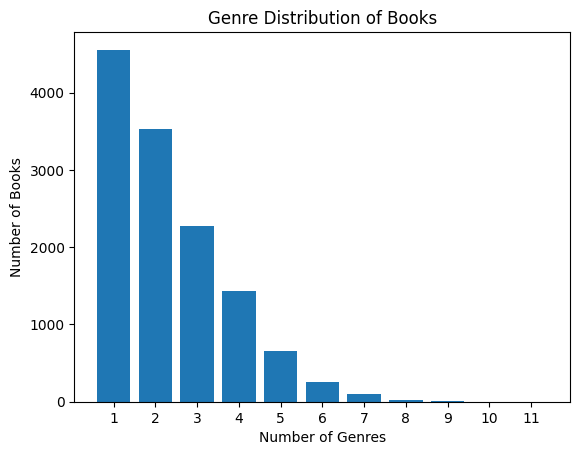

In [116]:
import matplotlib.pyplot as plt 

genre_dist = dict()
for x in df['formatted_genre']:
    if len(x) in genre_dist.keys():
        genre_dist[len(x)] += 1
    else:
        genre_dist[len(x)] = 1

print("Genre distribution:", genre_dist)

plt.bar(range(len(genre_dist)), sorted(genre_dist.values(), reverse=True), align='center')
plt.xticks(range(len(genre_dist)), sorted(list(genre_dist.keys())))
plt.title("Genre Distribution of Books")
plt.xlabel("Number of Genres")
plt.ylabel("Number of Books")
plt.show()

In [117]:
top_genre = dict()
for x in df['formatted_genre']:
    for g in x:
        if g in top_genre.keys():
            top_genre[g] += 1
        else:
            top_genre[g] = 1
sorted_genre = sorted(top_genre.items(), key=lambda item: item[1], reverse=True)
genre_freq = dict(sorted_genre)
print(sorted_genre)

[('Fiction', 4747), ('Speculative fiction', 4314), ('Science Fiction', 2870), ('Novel', 2463), ('Fantasy', 2413), ("Children's literature", 2122), ('Mystery', 1396), ('Young adult literature', 825), ('Suspense', 765), ('Crime Fiction', 753), ('Historical novel', 654), ('Thriller', 568), ('Horror', 511), ('Romance novel', 435), ('Historical fiction', 388), ('Detective fiction', 341), ('Adventure novel', 330), ('Non-fiction', 230), ('Alternate history', 226), ('Spy fiction', 190), ('Comedy', 145), ('Dystopia', 127), ('Autobiography', 124), ('Satire', 123), ('Gothic fiction', 112), ('Comic novel', 104), ('Biography', 102), ('Novella', 87), ('War novel', 87), ('Short story', 78), ('Autobiographical novel', 77), ('History', 73), ('Utopian and dystopian fiction', 67), ('Memoir', 67), ('High fantasy', 66), ('Humour', 62), ('Techno-thriller', 59), ('Apocalyptic and post-apocalyptic fiction', 56), ('Picture book', 49), ('Role-playing game', 48), ('Philosophy', 47), ('Steampunk', 47), ('Paranorm

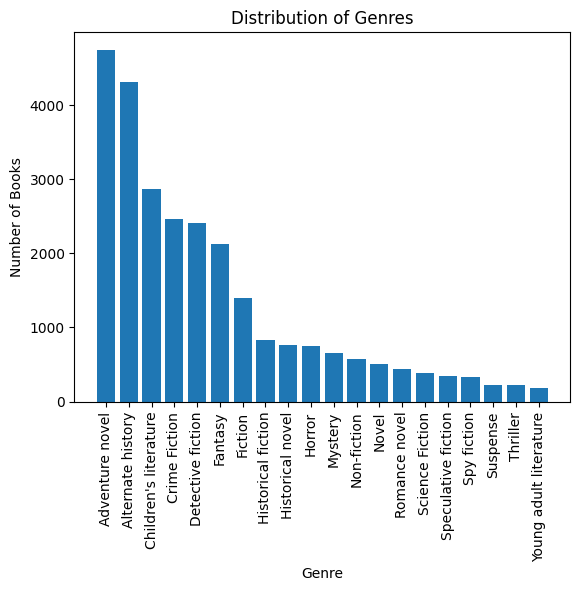

In [187]:
top_20_genres = dict(sorted_genre[:20])
plt.bar(range(len(top_20_genres)), sorted(top_20_genres.values(), reverse=True), align='center')
plt.xticks(range(len(top_20_genres)), sorted(list(top_20_genres.keys())))
plt.title("Distribution of Genres")
plt.xlabel("Genre")
plt.xticks(rotation=90)
plt.ylabel("Number of Books")
plt.show()

In [118]:
new_columns = []
#ignore = ['Fiction', 'Novel', 'Children\'s literature', 'Non-fiction', 'Novella']
ignore = []
for g in genre_freq.keys():
    if genre_freq[g] >= 5 and g not in ignore:
        new_columns.append(g)
        
print(new_columns)

['Fiction', 'Speculative fiction', 'Science Fiction', 'Novel', 'Fantasy', "Children's literature", 'Mystery', 'Young adult literature', 'Suspense', 'Crime Fiction', 'Historical novel', 'Thriller', 'Horror', 'Romance novel', 'Historical fiction', 'Detective fiction', 'Adventure novel', 'Non-fiction', 'Alternate history', 'Spy fiction', 'Comedy', 'Dystopia', 'Autobiography', 'Satire', 'Gothic fiction', 'Comic novel', 'Biography', 'Novella', 'War novel', 'Short story', 'Autobiographical novel', 'History', 'Utopian and dystopian fiction', 'Memoir', 'High fantasy', 'Humour', 'Techno-thriller', 'Apocalyptic and post-apocalyptic fiction', 'Picture book', 'Role-playing game', 'Philosophy', 'Steampunk', 'Paranormal romance', 'Bildungsroman', 'Western', 'Gamebook', 'Reference', 'Black comedy', 'Urban fantasy', 'Literary fiction', 'Military science fiction', 'Sociology', 'Sword and sorcery', 'Epistolary novel', 'Whodunit', 'Roman à clef', 'Absurdist fiction', 'Drama', 'Poetry', 'Psychological nov

In [119]:
default_value = 0
df = pd.concat([df, pd.DataFrame({col: default_value for col in new_columns}, index=df.index)], axis=1)

print(df.head())

                            title  \
0                     Animal Farm   
1              A Clockwork Orange   
2                      The Plague   
4            A Fire Upon the Deep   
5  All Quiet on the Western Front   

                                               genre  \
0  {"/m/016lj8": "Roman \u00e0 clef", "/m/06nbt":...   
1  {"/m/06n90": "Science Fiction", "/m/0l67h": "N...   
2  {"/m/02m4t": "Existentialism", "/m/02xlf": "Fi...   
4  {"/m/03lrw": "Hard science fiction", "/m/06n90...   
5  {"/m/098tmk": "War novel", "/m/016lj8": "Roman...   

                                             summary          token_title  \
0   Old Major, the old boar on the Manor Farm, ca...          animal farm   
1   Alex, a teenager living in near-future Englan...     clockwork orange   
2   The text of The Plague is divided into five p...               plague   
4   The novel posits that space around the Milky ...       fire upon deep   
5   The book tells the story of Paul Bäumer, a Ge...  q

In [120]:
for index,row in df.iterrows():
    for g in row['formatted_genre']:
        if g in new_columns:
            df.at[index, g] = 1

In [121]:
print(df.columns)
df = df.drop(labels=['genre', 'summary', 'formatted_genre'], axis=1)
print(df.columns)

Index(['title', 'genre', 'summary', 'token_title', 'token_summary',
       'title_summary', 'formatted_genre', 'Fiction', 'Speculative fiction',
       'Science Fiction',
       ...
       'Planetary romance', 'Treatise', 'Comic fantasy', 'Locked room mystery',
       'Soft science fiction', 'Campus novel', 'Social science fiction',
       'Essay', 'Urban fiction', 'Mashup'],
      dtype='object', length=141)
Index(['title', 'token_title', 'token_summary', 'title_summary', 'Fiction',
       'Speculative fiction', 'Science Fiction', 'Novel', 'Fantasy',
       'Children's literature',
       ...
       'Planetary romance', 'Treatise', 'Comic fantasy', 'Locked room mystery',
       'Soft science fiction', 'Campus novel', 'Social science fiction',
       'Essay', 'Urban fiction', 'Mashup'],
      dtype='object', length=138)


In [122]:
import numpy as np
df = df.sample(frac=1)

X = df[df.columns[:4]]
y = np.asarray(df[df.columns[4:]])

vectorizer = TfidfVectorizer(max_features=2500, max_df=0.9)
vectorizer.fit(X["title_summary"])

TfidfVectorizer(max_df=0.9, max_features=2500)

In [123]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_tfidf = vectorizer.transform(X_train["title_summary"])
X_test_tfidf = vectorizer.transform(X_test["title_summary"])

In [124]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss

In [125]:
# Logistic Regression
lr = LogisticRegression(class_weight="balanced",    #accounts for class imbalance
multi_class ="multinomial", #accounts for multiclass
)
clf_1 = MultiOutputClassifier(lr)
clf_1.fit(X_train_tfidf, y_train)
prediction_1 = clf_1.predict(X_test_tfidf)
print('Accuracy Score: ', accuracy_score(y_test, prediction_1))
print('Hamming Loss: ', round(hamming_loss(y_test, prediction_1), 2))

Accuracy Score:  0.0650058388478007
Hamming Loss:  0.02


In [80]:
def getGenreNames(cats):
    genres = []
    for i in range(len(cats)):
        if cats[i] == 1:
            genres.append(new_columns[i])
    return genres

import csv

fields = ['Title', 'Actual Genres', 'Predicted Genres']
rows = []

for i in range(len(y_test)):
    row = []
    row.append(X_test.iloc[i]['title'])
    row.append(getGenreNames(y_test[i]))
    row.append(getGenreNames(prediction_1[i]))
    rows.append(row)

with open('genre_classifications.csv', 'w', encoding="utf-8") as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(fields)
    csvwriter.writerows(rows)

# Genre Recommendations

## Load in user data

In [126]:
# Read in data from file & remove extraneous columns
ratings = pd.read_csv('data/Books_rating.csv')

In [127]:
ratings.head(10)

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...
5,0826414346,Dr. Seuss: American Icon,NaN,A2F6NONFUDB6UK,Malvin,2/2,4.0,1127174400,One of America's greatest creative talents,"""Dr. Seuss: American Icon"" by Philip Nel is a ..."
6,0826414346,Dr. Seuss: American Icon,NaN,A14OJS0VWMOSWO,Midwest Book Review,3/4,5.0,1100131200,A memorably excellent survey of Dr. Seuss' man...,Theodor Seuss Giesel was best known as 'Dr. Se...
7,0826414346,Dr. Seuss: American Icon,NaN,A2RSSXTDZDUSH4,J. Squire,0/0,5.0,1231200000,Academia At It's Best,When I recieved this book as a gift for Christ...
8,0826414346,Dr. Seuss: American Icon,NaN,A25MD5I2GUIW6W,"J. P. HIGBED ""big fellow""",0/0,5.0,1209859200,And to think that I read it on the tram!,Trams (or any public transport) are not usuall...
9,0826414346,Dr. Seuss: American Icon,NaN,A3VA4XFS5WNJO3,Donald Burnside,3/5,4.0,1076371200,Fascinating account of a genius at work,"As far as I am aware, this is the first book-l..."


In [128]:
print(ratings.loc[ratings['profileName'] == 'Malvin'])

                 Id                                              Title  \
5        0826414346                           Dr. Seuss: American Icon   
81192    B0001BJECI  Pigs at the Trough: How Corporate Greed and Po...   
97694    0814767109  The Silicon Valley of Dreams: Environmental In...   
127002   0393322963  The Bush Dyslexicon: Observations on a Nationa...   
154774   B00007FYI8  Database Nation: The Death of Privacy in the 2...   
301366   0393060942  Kingdom Coming: The Rise of Christian Nationalism   
390743   B000GLYWH0                           Manufacturing Discontent   
441277   1567513220  The Profits of Extermination: Big Mining in Co...   
553531   0743530195  Reefer Madness: Sex, Drugs, and Cheap Labor in...   
596160   0415351820  Beauty and Misogyny: Harmful Cultural Practice...   
697505   0226210723  Projections of Power: Framing News, Public Opi...   
742508   079145844X  The Micro-Politics of Capital: Marx and the Pr...   
839224   1551642603  Filtering the New

In [129]:
books = pd.read_csv('data/books_data.csv')

In [159]:
def getLikedBooks(profileName):
    liked_books = ratings.loc[ratings['profileName'] == profileName]
    book_list = []
    for index, row in liked_books.iterrows():
        if row['review/score'] >= 5.0:
            book_list.append(row['Title'])
    return book_list

def getBookDescription(title):
    return books.loc[books['Title'] == title]

In [151]:
print(getLikedBooks('John Granger'))

['Dr. Seuss: American Icon', 'Walking Tall in Babylon: Raising Children to Be Godly and Wise in a Perilous World', 'The Magic Ring']


In [160]:
title = getLikedBooks('John Granger')[0]
description = getBookDescription(title).iloc[0]['description']
new_title_summary = title + " " + description

In [179]:
new_tokenized = nltk.word_tokenize(clean_text(new_title_summary.lower()))
new_tokenized = [word for word in new_tokenized if word not in (stop)]
new_tokenized = ' '.join(new_tokenized)
print(new_tokenized)

dr. seuss : american icon philip nel takes fascinating look key aspects seuss 's career - poetry , politics , art , marketing , place popular imagination . '' `` nel argues convincingly dr. seuss one influential poets america . nonsense verse , like lewis carroll edward lear , changed language , giving us new words like `` nerd . '' seuss 's famously loopy artistic style - nel terms `` energetic cartoon surrealism '' - equally important , inspiring artists like filmmaker tim burton illustrator lane smith . -- back cover


In [183]:
new_tokenized_tfidf = vectorizer.transform([new_tokenized])
new_pred = clf_1.predict(new_tokenized_tfidf)
print(new_pred)
print(getGenreNames(new_pred[0]))

[[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
['Novel', 'Young adult literature', 'Non-fiction']
